In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
!ls
!grep -n "K00399" ghostKoala_result.txt

22bins_C-Plyase_table.csv       Ontol_KO_L2_Color_KEY_whh0.txt
231_kaiju_taxon_per50.csv       Ontology_KO_CNPSch4_Fm_whh0.txt
2bins_CH4oxid.csv               ghostKoala_result.txt
450_bins_checkm.xlsx            sort_kegg_2_add_taxon.ipynb
L1-3_bin_counts.csv
42064:Salt_Pond_MetaG_R1_A_D2_MG_DASTool_bins_concoct_out.21-NODE_638_length_42397_cov_3.63714_2	K00399


# 1. number of bins in the ghostKoala result

In [2]:
df = pd.read_csv("ghostKoala_result.txt",header=None)
df = df[0].str.split('\t',expand=True)
len(set([a[0] for a in df[0].str.split("-")]))

309

# 2. ghostKoala result to table

In [3]:
def convert(pwd):
    df = pd.read_csv(pwd,header=None)
    df = df[0].str.split('\t',expand=True)
    dft = df[0].str.split('-',expand=True)
    df[0] = dft[0]
    df[2] = dft[1]
    df = df.dropna() # 454482 anotated / total 994598  45.7% anotated
    df1 = pd.DataFrame(df.groupby([0,1])[2].size()).reset_index()
    df2 = pd.pivot_table(df1,index=1,columns=0,values=2)
    #df2.index = df2.index.str.replace("Salt_Pond_MetaG_","").str.replace("Salt_Pond_MetaG","").str.replace("_MG_DASTool_bins","").str.replace(".metabat","_metabat").str.replace(".concoct_out","_concoct").str.replace("concoct_out","concoct").str.replace("_restored","_r")
    return df2

# 3. add checkm and taxon to table

In [5]:
kg_pwd = "ghostKoala_result.txt"
checkm_pwd = "450_bins_checkm.xlsx"
taxon_pwd = "231_kaiju_taxon_per50.csv"
def convert_kg_add_checkm_taxon(kg_pwd,checkm_pwd,taxon_pwd):
    df2 = convert(kg_pwd)
    dfC_P2 = pd.read_excel(checkm_pwd,index_col=0)
    dfC_P2.index = dfC_P2.index.str.replace(".contigs","")
    df_count_checkm = pd.merge(df2,dfC_P2,left_index=True,right_index=True,how="inner")
    #df2.sort_index().head(20)
    df_taxon = pd.read_csv(taxon_pwd,index_col=0)
    df_taxon = df_taxon.set_index("Bin ID")
    df_count_checkm_taxon = pd.merge(df_count_checkm,df_taxon,left_index=True,right_index=True,how="left")
    return df_count_checkm_taxon
df_count_checkm_taxon = convert_kg_add_checkm_taxon(kg_pwd,checkm_pwd,taxon_pwd)
df_count_checkm_taxon.to_csv("310_kgcount_checkm_taxon.csv")

# 4. keep only taxon and kegg counts

In [9]:
df_count_checkm_taxon = pd.read_csv("310_kgcount_checkm_taxon.csv",index_col=0)

rm_col = df_count_checkm_taxon.columns[-15:-1]
df1 = df_count_checkm_taxon.drop(rm_col,1)
#df2 = df1.loc[df1["taxon"].dropna().sort_values().index].T
df1.index = df1.index.str.replace("Salt_Pond_MetaG_","").str.replace("Salt_Pond_MetaG","").str.replace("_MG_DASTool_bins","")
df1.index = df1.index.str.replace("concoct_out","concoct").str.replace("restored_","r_")
df2 = df1.loc[df1["taxon"].dropna().sort_values().index].reset_index().set_index(["index","taxon"]).T


# 5. add ontology 

In [10]:
CNPSch4_Fm_KO = pd.read_csv("Ontology_KO_CNPSch4_Fm_whh0.txt", sep='\t', index_col=0)
CNPSch4_Fm_KO = CNPSch4_Fm_KO.loc[:,['L1','L2','L3','KO','mid_name']]
df3 = pd.merge(CNPSch4_Fm_KO,df2,left_on ="KO",right_index=True,how="left")
df_colo = pd.read_csv("Ontol_KO_L2_Color_KEY_whh0.txt", sep='\t', index_col=0)
df3 = pd.merge(df3,df_colo,how="left",left_on="L2",right_on="L2")


/anaconda/lib/python2.7/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


# 6. group L3 to sum kegg count for each bin

In [11]:
bin_list = df3.iloc[:,5:-1].columns
df4 = df3.groupby(["L1","L2","color","L3"])[bin_list].sum()
df5 = df4.reset_index()
df6 = df5.set_index(["L1","L2","L3"]).T
#["color"] + ["-".join(a) for a in list(df6.index)[1:]]
df6.index = ["color"] + ["\t".join(a) for a in list(df6.index)[1:]]
df7 = df6.T
df7["index"] = (["\t".join(a) for a in list(df6.T.index)])
df8 = df7.set_index("index")
df8.iloc[:,1:] = df8.iloc[:,1:].fillna(0).astype(float)
#df9 = df8.iloc[:,1:]
df8.to_csv("L1-3_bin_counts.csv")

# 7. read L1-3_bin_counts.csv

In [12]:
xx = pd.read_csv("L1-3_bin_counts.csv",index_col=0)
#xx.iloc[:,1:].T.iloc[:10]
#xx.iloc[:,0]

/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


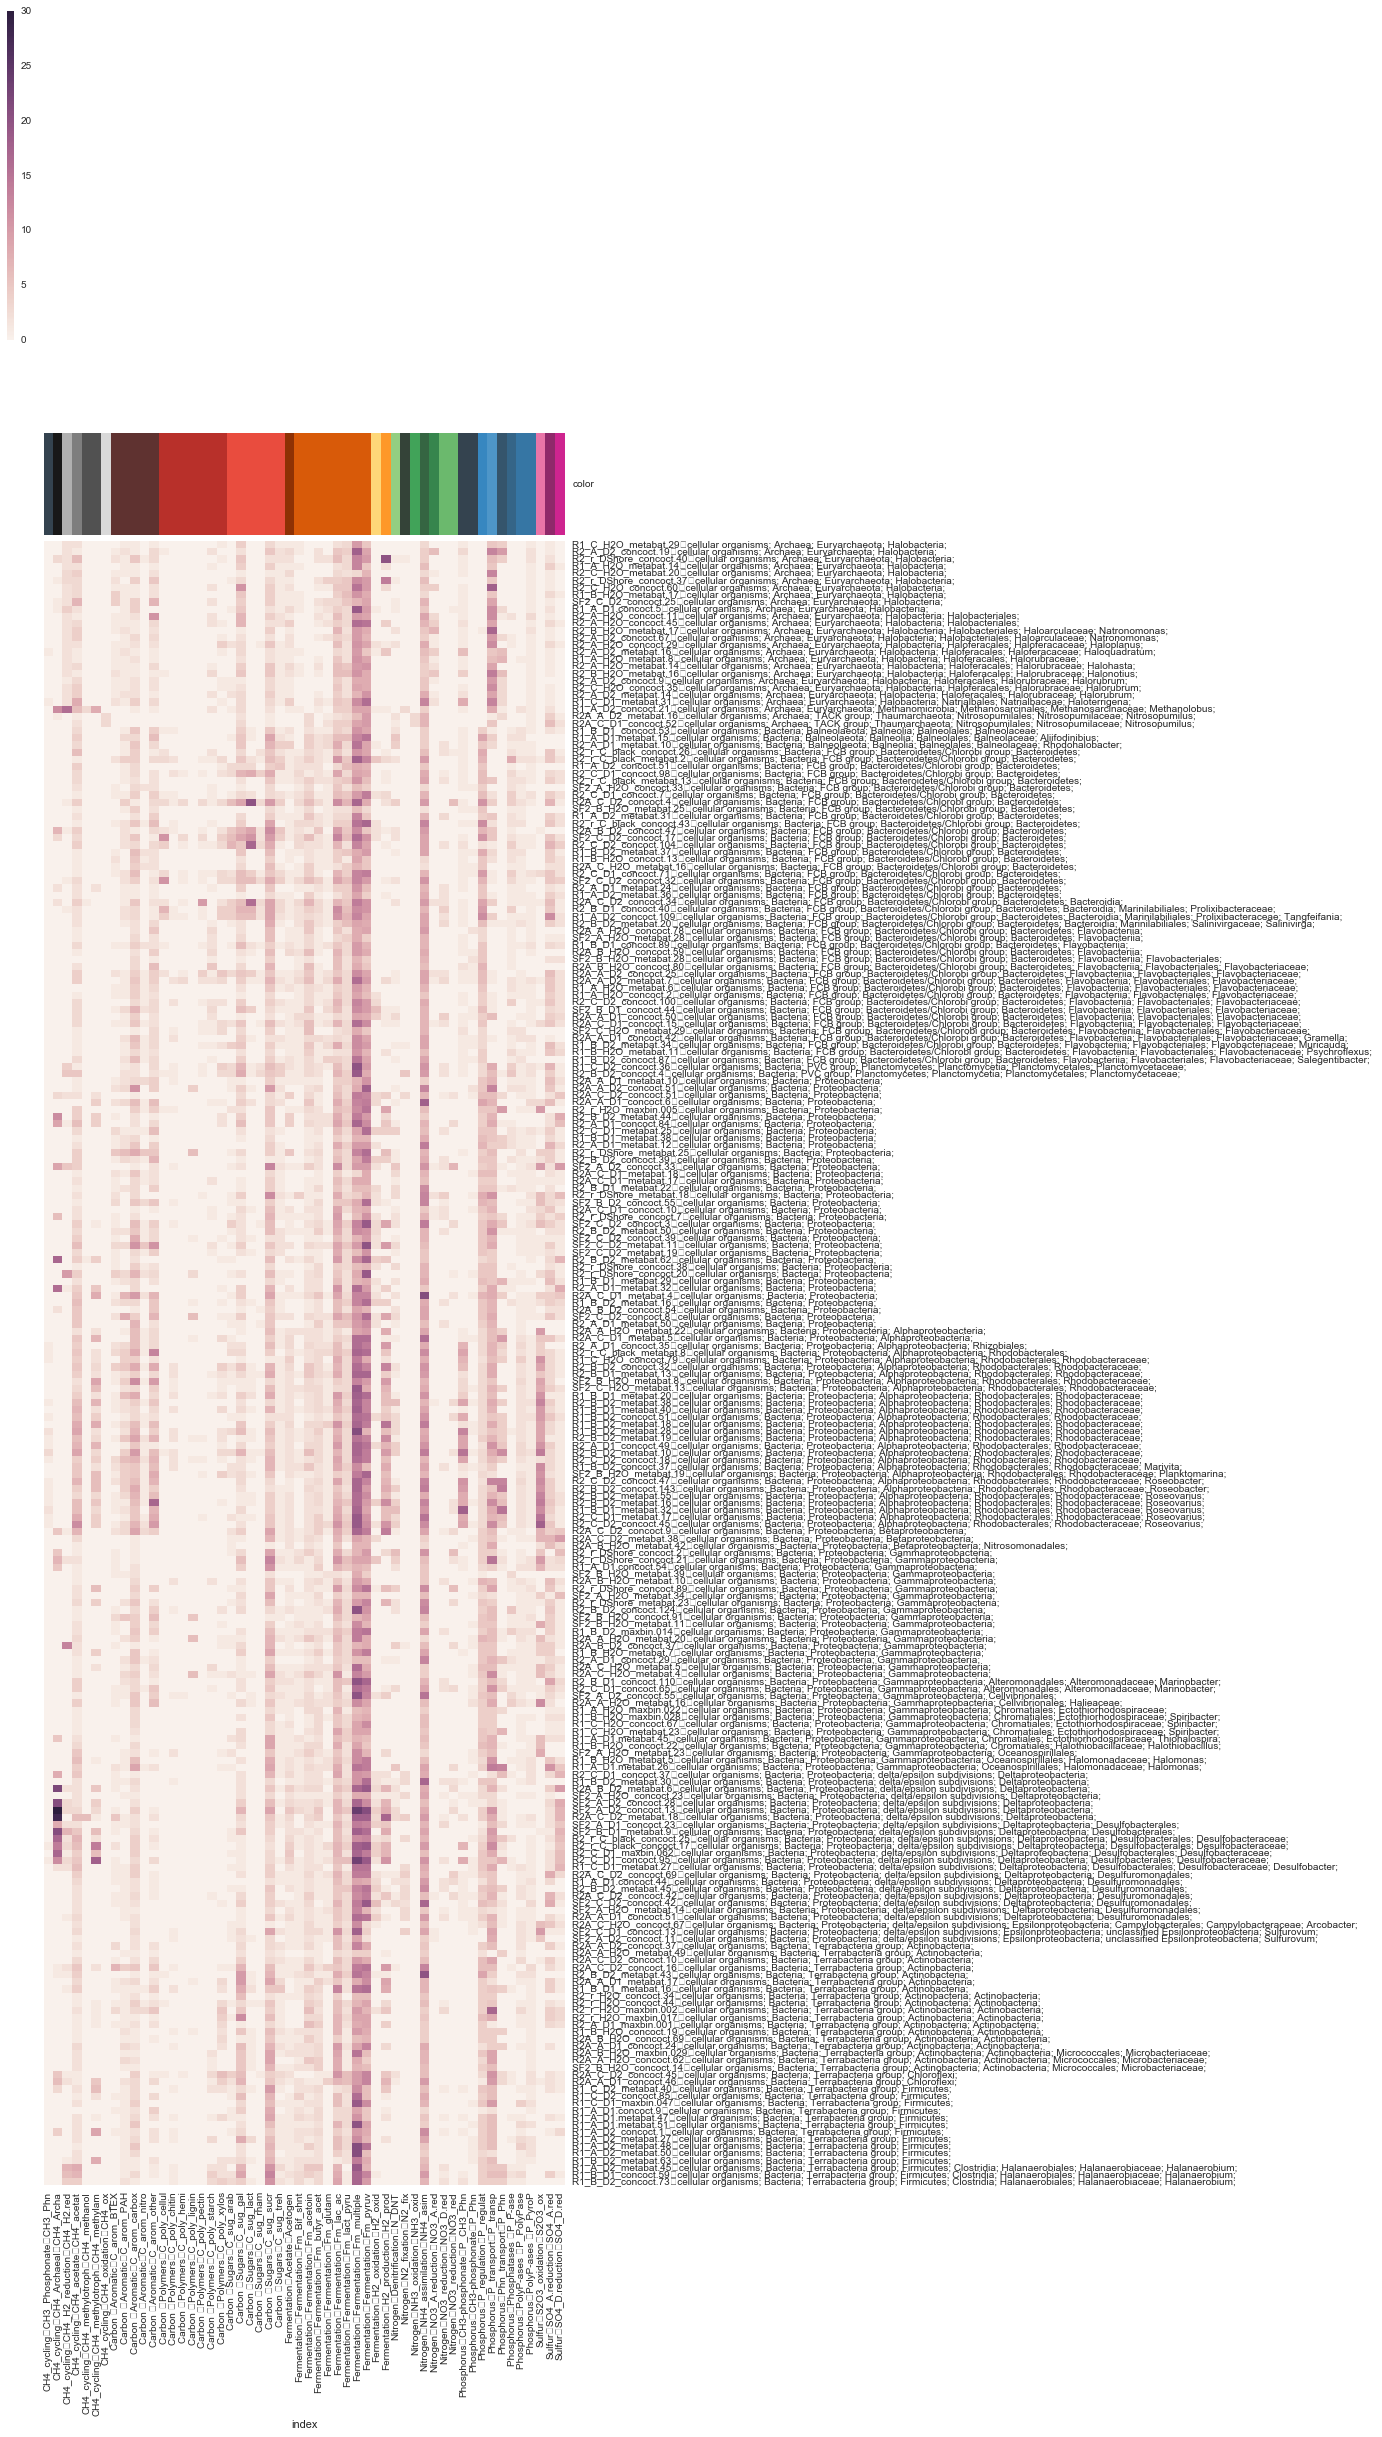

In [13]:
plt.figure()
cm = sns.clustermap(xx.iloc[:,1:].T,row_cluster=False, col_cluster=False,square=False,figsize = (10,40),col_colors=xx.iloc[:,0]);          # , figsize = (10,20))         
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)   # rotate ticks
plt.show()